In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
command_file_name = "../data/command/japan_command.json"
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
celeri.create_output_folder(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

# Get elastic operators and TDE smoothing operators

In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)
# celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

Using precomputed elastic operators


# Calculate non-elastic operators

In [5]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Plot input data

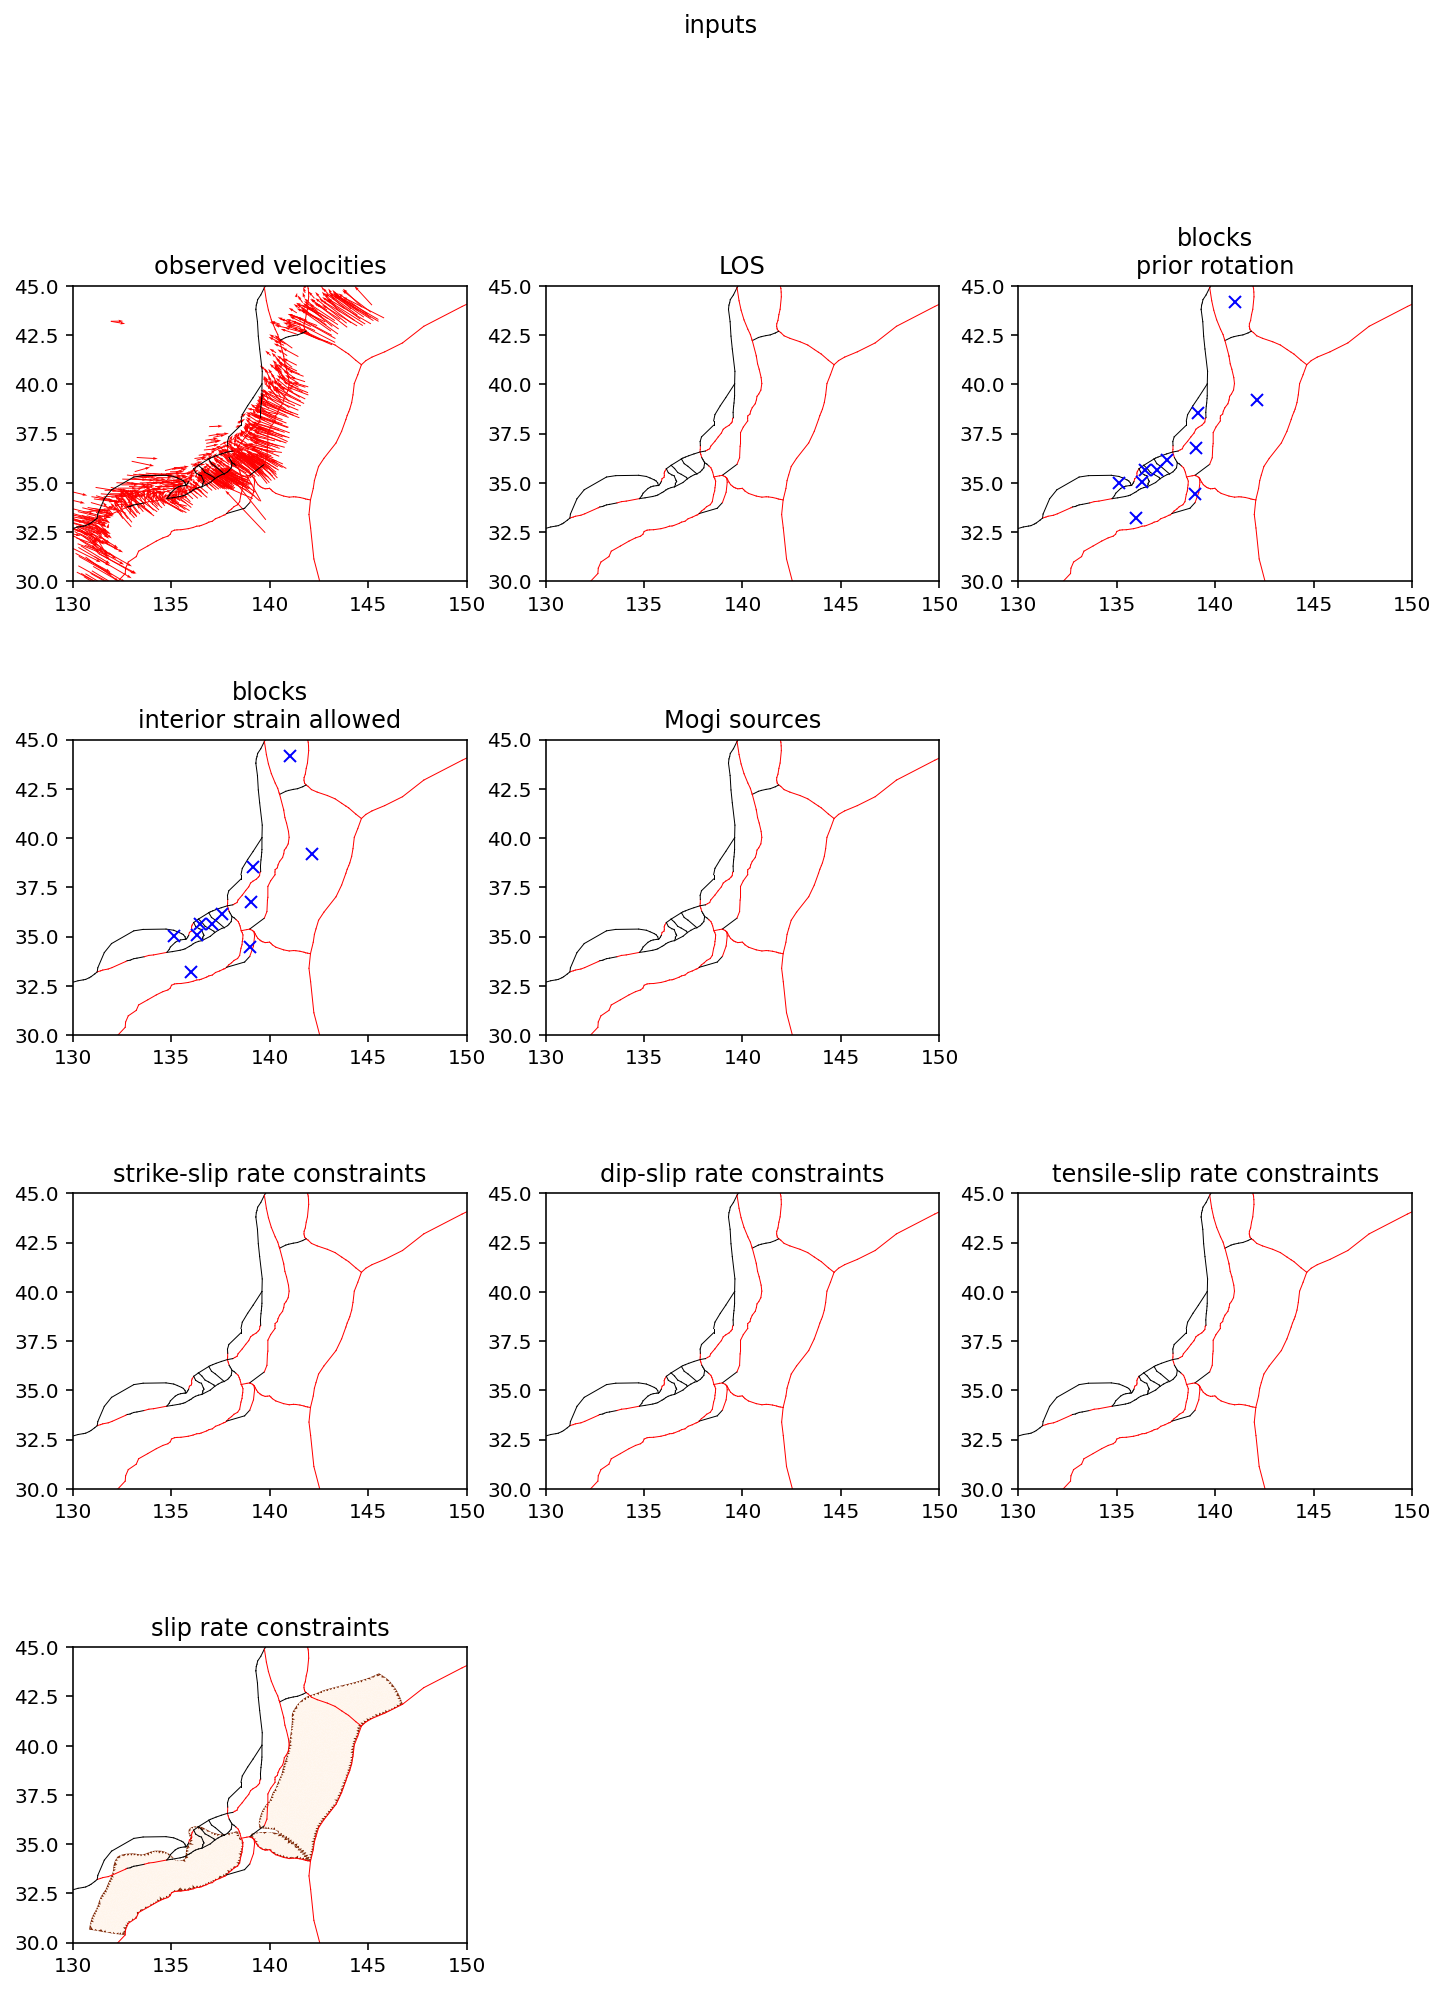

In [6]:
celeri.plot_input_summary(segment, station, block, meshes, mogi, sar, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [7]:
index, estimation = celeri.assemble_and_solve_dense(command, assembly, operators, station, block, meshes)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

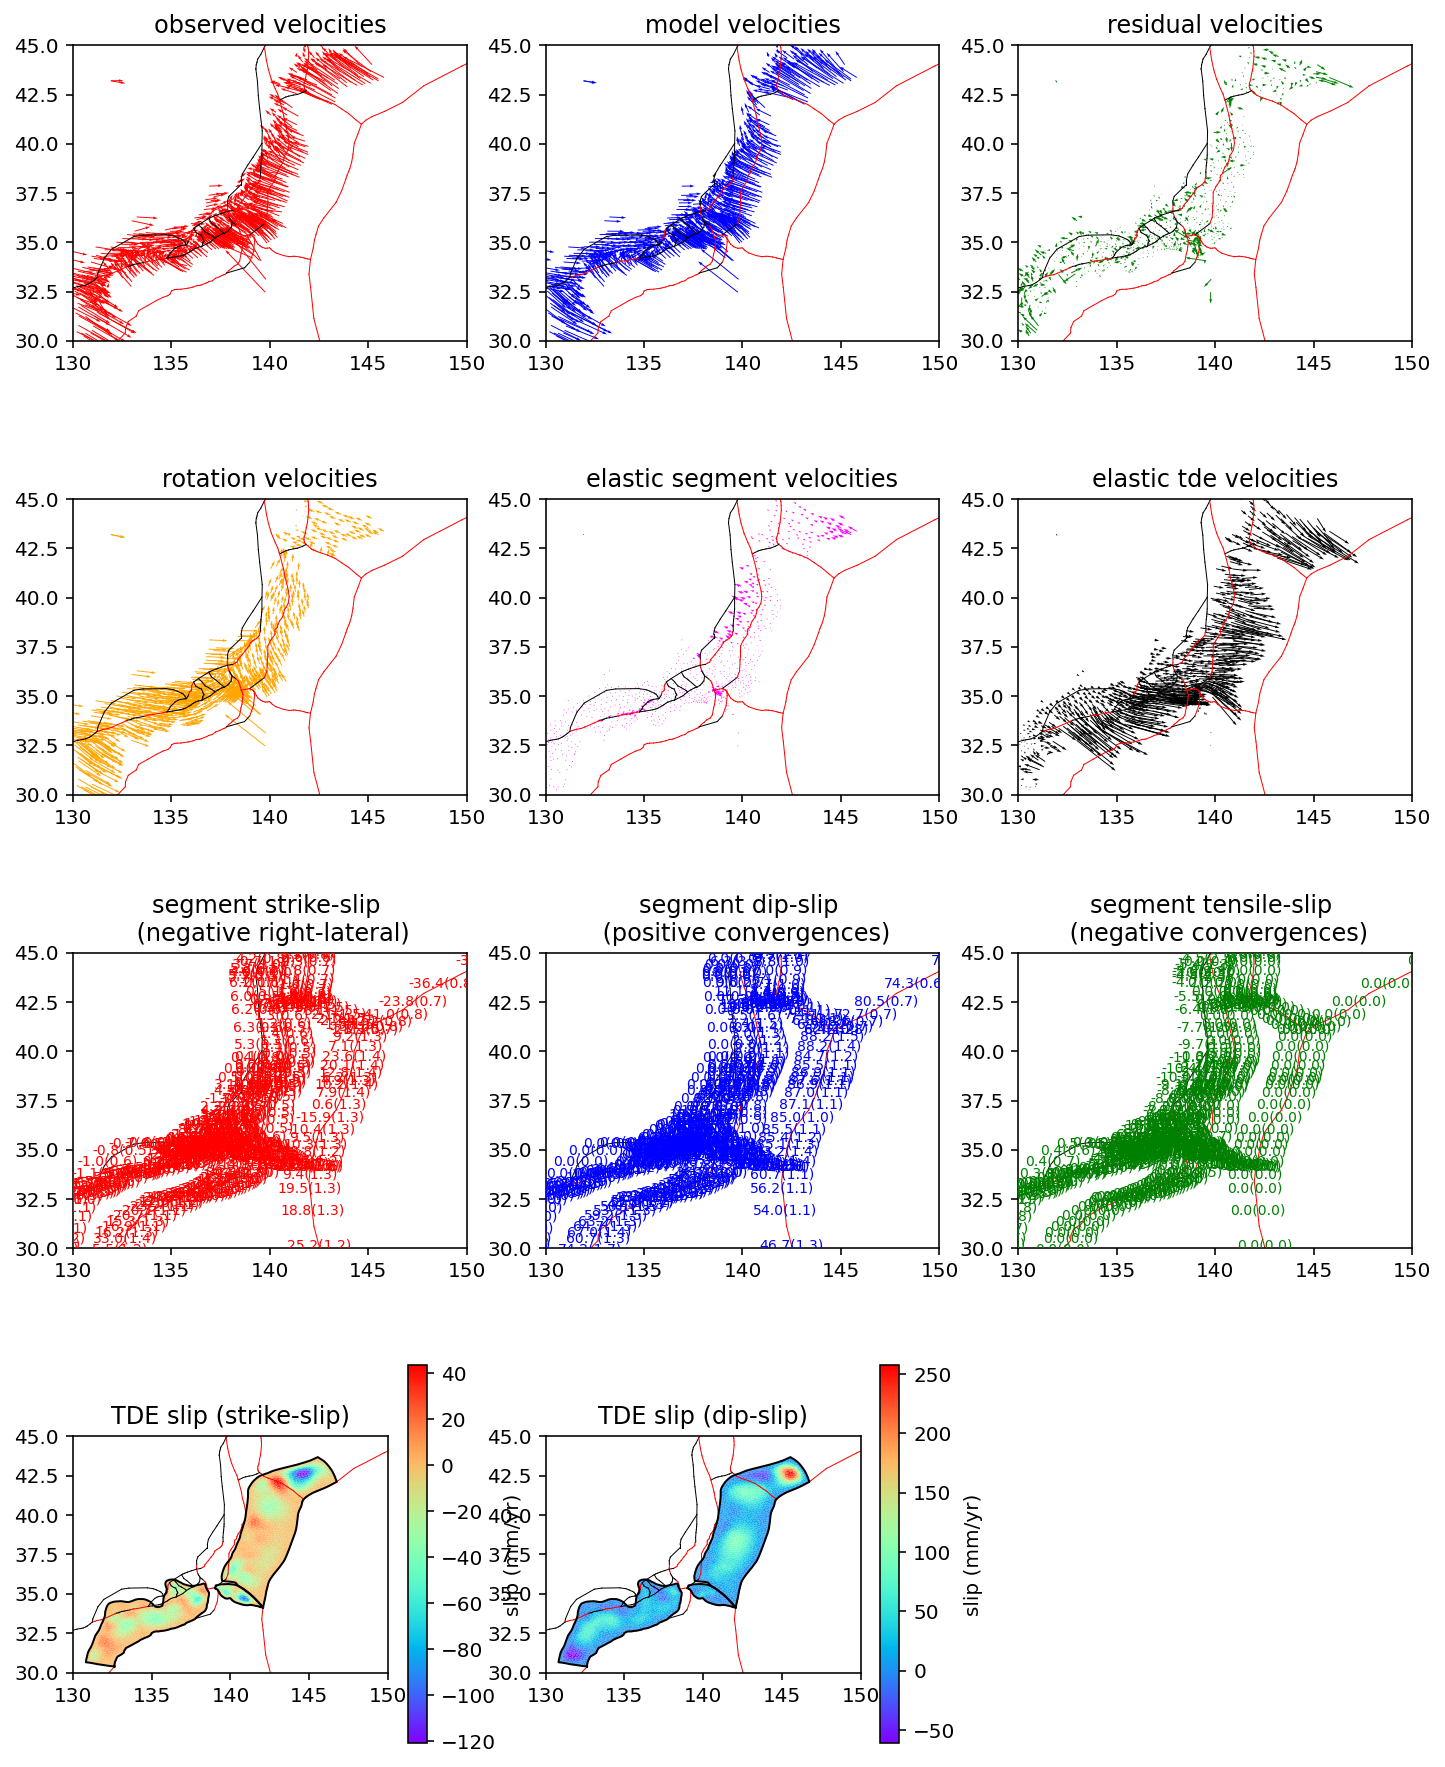

In [8]:
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=(130.0, 150.0), lat_range=(30.0, 45.0), quiver_scale=1e2)

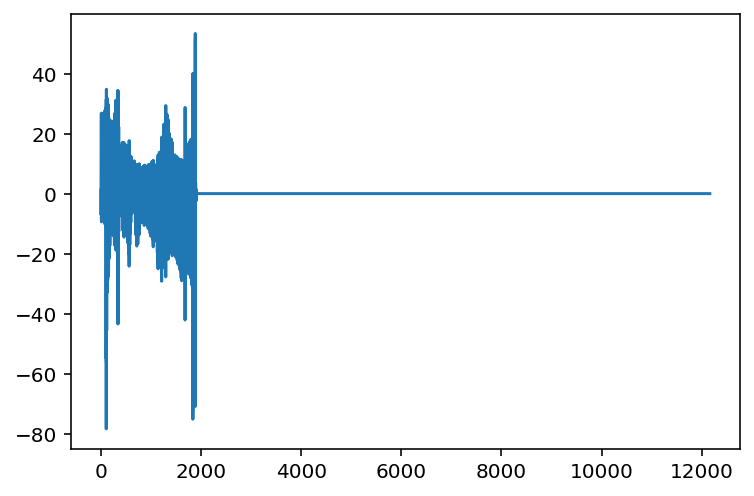

In [13]:
estimation.weighting_vector

plt.figure()
plt.plot(estimation.data_vector)

plt.show()